# Goal: Explore using Kernel Density Estimators (KDEs) for modeling PDFs

# Steps
1. Randomly sample from different distributions
2. Apply KDEs with different choices of kernel and bandwidth to each sample
3. Check how close to optimal each choice was

# 1. Randomly sample from different distributions
## 1.1 Random sample of small arbitrary number sequence

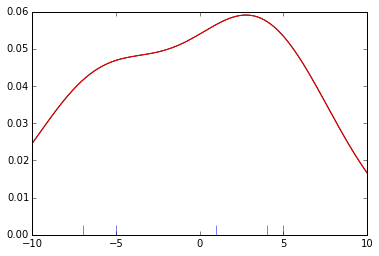

In [82]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x1 = np.array([-7, -5, 1, 4, 5], dtype=np.float)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x1, np.zeros(x1.shape), 'b+', ms=20) # plot x1 values as 1D values.
x_eval = np.linspace(-10, 10, num=200) # get 200 equidistant points between -10 and 10.
kde1 = stats.gaussian_kde(x1)
kde2 = stats.gaussian_kde(x1, bw_method='silverman')
ax.plot(x_eval, kde1(x_eval), 'k-', label="Scott's Rule")
ax.plot(x_eval, kde1(x_eval), 'r-', label="Silverman's Rule")
plt.show() # Not a lot of difference between Scott's and Silverman's rule.

Scott's and Silverman's rule are pretty much identical in this case (try commenting one of the plots out to see the other). Furthermore, it looks like out bandwidth is too high (too biased) since our kde model doesn't really contain much information about our original sample. 

We'll define a new bandwidth based on Scott's rule multiplied by a constant factor $k$:

$$
n^\frac{{-1}}{(d+4)}*k
$$

where $n$ is the number of samples, and $d$ is the dimension of the dataset.

In [83]:
def my_kde_bandwidth(obj, fac=1./5):
    """We use Scott's Rule, multiplied by a constant factor."""
    return np.power(obj.n, -1./(obj.d+4)) * fac

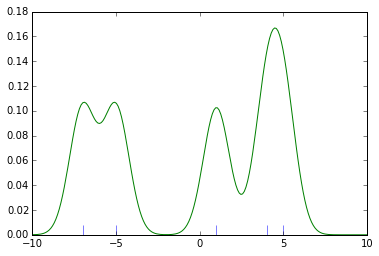

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x1, np.zeros(x1.shape), 'b+', ms=20)  # rug plot
kde3 = stats.gaussian_kde(x1, bw_method=my_kde_bandwidth)
ax.plot(x_eval, kde3(x_eval), 'g-', label="With smaller BW")

We can see that by shrinking our new bandwidth (multiplying by a constant factor of $1/5$) we increased our variance and captured more information in our dataset.

Also note that by setting our bandwidth very narrow, we are simply summing up gaussian distributions around each data point. This summing of Gaussians demonstrated how KDE is an 'improved' version of a histogram that uses kernel distributions other than just box plots in estimating the PDF.

## 1.2 Sample from normal distribution

In [90]:
from sklearn.neighbors import KernelDensity



In [122]:
np.random.seed(12456)
x1 = np.random.normal(size=200)  # random data, normal distribution
xs = np.linspace(x1.min()-1, x1.max()+1, 200)

# Build the Scipy gaussian KDE
kde1 = stats.gaussian_kde(x1)
kde2 = stats.gaussian_kde(x1, bw_method='silverman')

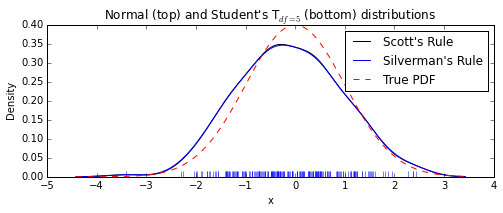

In [123]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(211)
ax1.plot(x1, np.zeros(x1.shape), 'b+', ms=12)  # rug plot
ax1.plot(xs, kde1(xs), 'k-', label="Scott's Rule")
ax1.plot(xs, kde2(xs), 'b-', label="Silverman's Rule")

ax1.plot(xs, stats.norm.pdf(xs), 'r--', label="True PDF")

ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.set_title("Normal (top) and Student's T$_{df=5}$ (bottom) distributions")
ax1.legend(loc=1)

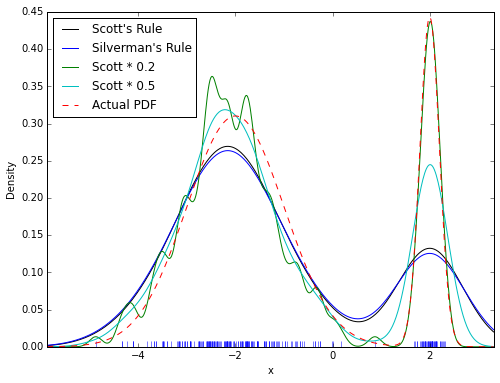

In [124]:
from functools import partial

loc1, scale1, size1 = (-2, 1, 175)
loc2, scale2, size2 = (2, 0.2, 50)
x2 = np.concatenate([np.random.normal(loc=loc1, scale=scale1, size=size1),
                     np.random.normal(loc=loc2, scale=scale2, size=size2)])

x_eval = np.linspace(x2.min() - 1, x2.max() + 1, 500)

kde = stats.gaussian_kde(x2)
kde2 = stats.gaussian_kde(x2, bw_method='silverman')
kde3 = stats.gaussian_kde(x2, bw_method=partial(my_kde_bandwidth, fac=0.2))
kde4 = stats.gaussian_kde(x2, bw_method=partial(my_kde_bandwidth, fac=0.5))

pdf = stats.norm.pdf
bimodal_pdf = pdf(x_eval, loc=loc1, scale=scale1) * float(size1) / x2.size + \
              pdf(x_eval, loc=loc2, scale=scale2) * float(size2) / x2.size
    
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(x2, np.zeros(x2.shape), 'b+', ms=12)
ax.plot(x_eval, kde(x_eval), 'k-', label="Scott's Rule")
ax.plot(x_eval, kde2(x_eval), 'b-', label="Silverman's Rule")
ax.plot(x_eval, kde3(x_eval), 'g-', label="Scott * 0.2")
ax.plot(x_eval, kde4(x_eval), 'c-', label="Scott * 0.5")
ax.plot(x_eval, bimodal_pdf, 'r--', label="Actual PDF")

ax.set_xlim([x_eval.min(), x_eval.max()])
ax.legend(loc=2)
ax.set_xlabel('x')
ax.set_ylabel('Density')
plt.show()

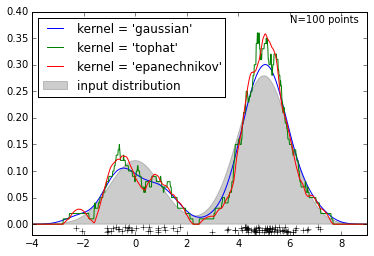

In [130]:
from scipy.stats import norm

#----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, 0.3 * N),
                    np.random.normal(5, 1, 0.7 * N)))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig = plt.figure(figsize=(16, 12))
fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')

for kernel in ['gaussian', 'tophat', 'epanechnikov']:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

# Multivariate estimation

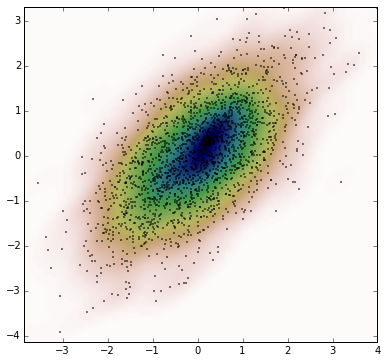

In [125]:
def measure(n):
    """Measurement model, return two coupled measurements."""
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2

m1, m2 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel.evaluate(positions).T, X.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.show()